In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
np.random.seed=20

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        #layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
			  layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
			  layers.RandomBrightness((-0.1,0.1),value_range=(0, 0.2)),
        tf.keras.layers.GaussianNoise(0.3, seed=20)

    ]
)

# Load some data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
input_shape = x_train.shape[1:]
y_trainRandomised=y_train.copy()
np.random.shuffle(y_trainRandomised)
classes = 10


from sklearn.model_selection import train_test_split
#zebysmy nie uczyli na tescie

x_t, x_val, y_t, y_val = train_test_split(x_train, y_trainRandomised, test_size=0.2, random_state=20)

# Create a tf.data pipeline of augmented images (and their labels)
train_dataset = tf.data.Dataset.from_tensor_slices((x_t, y_t))
train_dataset = train_dataset.batch(128).map(lambda x, y: (data_augmentation(x), y))#bylo16

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.batch(128).map(lambda x, y: (data_augmentation(x), y))


# Create a model and train it on the augmented image data
inputs = keras.Input(shape=input_shape)
x = layers.Rescaling(1.0 / 255)(inputs)  # Rescale inputs
output = keras.applications.ResNet50(  # Add the rest of the model
    weights=None, input_shape=input_shape, classes=classes, include_top=False
)(x)
outputs = keras.layers.Dense(10, activation='softmax')(output)
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])#rmsprop

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 dense (Dense)               (None, 1, 1, 10)          20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [3]:
y_trainRandomised.shape

(50000, 1)

In [4]:
print(y_train[0:5])
print(y_trainRandomised[0:5])

[[6]
 [9]
 [9]
 [4]
 [1]]
[[4]
 [5]
 [3]
 [1]
 [1]]


Epoch 1/3
3/3 [==============================] - 63s 23s/step - loss: 4.5222 - accuracy: 0.0915 - val_loss: 2.3056 - val_accuracy: 0.0982
Epoch 2/3
3/3 [==============================] - 49s 20s/step - loss: 5.3891 - accuracy: 0.0972 - val_loss: 2.3063 - val_accuracy: 0.0997
Epoch 3/3
3/3 [==============================] - 52s 22s/step - loss: 4.5348 - accuracy: 0.1023 - val_loss: 2.3064 - val_accuracy: 0.0995


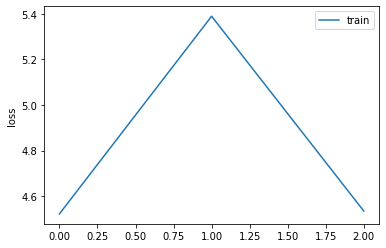

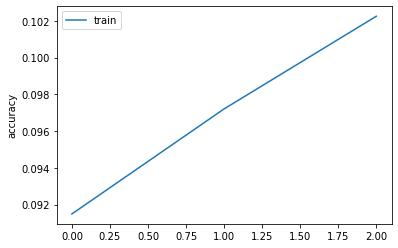

In [5]:
history_resnetOn = model.fit(train_dataset,validation_data=validation_dataset ,epochs=100,batch_size=512) #,, steps_per_epoch=3 tego nie chcemy chyba, bedzie sie duzo dluzej trenowal jak by co, bo bedzie 2500 krokow zamiast 5

plt.plot(history_resnetOn.history['loss'], label='train')
# plt.plot(history_resnetOn.history['val_loss'], label='val')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history_resnetOn.history['accuracy'], label='train')
# plt.plot(history_resnetOn.history['val_accuracy'], label='val')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [6]:
print(history_resnetOn.history)

{'loss': [4.522246360778809, 5.389097690582275, 4.534801483154297], 'accuracy': [0.09149169921875, 0.0972086563706398, 0.1022542342543602], 'val_loss': [2.3055756092071533, 2.3063201904296875, 2.3064489364624023], 'val_accuracy': [0.09816242754459381, 0.0996856540441513, 0.09947598725557327]}


In [7]:
#model.save('localstorage://my-model')

In [8]:
# Create a model and train it on the augmented image data



#model = tf.keras.models.load_model('saved_model/my_model')

# inputs = keras.Input(shape=input_shape)
# x = layers.Rescaling(1.0 / 255)(inputs)  # Rescale inputs
# outputs = keras.applications.ResNet50(  # Add the rest of the model
#     weights=None, input_shape=input_shape, classes=classes
# )(x)
# model = keras.Model(inputs, outputs)
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])#rmsprop


modelResnetStatic=keras.Sequential([
    model.get_layer(name="input_1"),
    model.get_layer(index=1),
    model.get_layer(index=2),
    layers.Dense(10, activation='softmax', kernel_initializer='he_uniform'),

    
    #(trainable# bez ostatniej warsty, train = off, zaimportowane wagi


])
modelResnetStatic.layers[0].trainable = False
modelResnetStatic.layers[1].trainable = False
modelResnetStatic.layers[2].trainable = True


modelResnetStatic.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelResnetStatic.summary()


#history_resnetStatic = modelResnetStatic.fit(train_datasetRaw,validation_data=validation_datasetnewRaw, steps_per_epoch=5,epochs=5,/)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 dense_1 (Dense)             (None, 1, 1, 10)          20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
x_t, x_val, y_t, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=20)


# Create a tf.data pipeline of augmented images (and their labels)
train_dataset = tf.data.Dataset.from_tensor_slices((x_t, y_t))
train_dataset = train_dataset.batch(128).map(lambda x, y: (data_augmentation(x), y))#bylo16

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.batch(128).map(lambda x, y: (data_augmentation(x), y))

Epoch 1/3
3/3 [==============================] - 28s 13s/step - loss: 2.3106 - accuracy: 0.0928 - val_loss: 2.3055 - val_accuracy: 0.1015
Epoch 2/3
3/3 [==============================] - 27s 14s/step - loss: 2.3088 - accuracy: 0.1146 - val_loss: 2.3068 - val_accuracy: 0.1015
Epoch 3/3
3/3 [==============================] - 25s 13s/step - loss: 2.2966 - accuracy: 0.1094 - val_loss: 2.3046 - val_accuracy: 0.1015


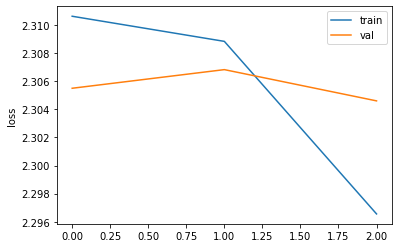

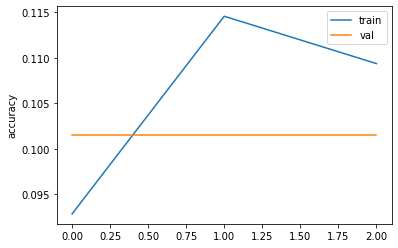

In [10]:
history_resnetOff = modelResnetStatic.fit(train_dataset,validation_data=validation_dataset  ,epochs=30,batch_size=512) #steps_per_epoch=3 tego nie chcemy chyba, bedzie sie duzo dluzej trenowal jak by co, bo bedzie 2500 krokow zamiast 5

plt.plot(history_resnetOff.history['loss'], label='train')
plt.plot(history_resnetOff.history['val_loss'], label='val')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history_resnetOff.history['accuracy'], label='train')
plt.plot(history_resnetOff.history['val_accuracy'], label='val')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [11]:
modelResnetStatic.evaluate(x_test,y_test)

313/313 [==============================] - 31s 96ms/step - loss: 2.3064 - accuracy: 0.0999


[2.306361436843872, 0.09992994368076324]